In [1]:
def set_hadoop_config(credentials):
    prefix = "fs.swift.service." + credentials['name']
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + ".auth.url", credentials['auth_url']+'/v3/auth/tokens')
    hconf.set(prefix + ".auth.endpoint.prefix", "endpoints")
    hconf.set(prefix + ".tenant", credentials['project_id'])
    hconf.set(prefix + ".username", credentials['user_id'])
    hconf.set(prefix + ".password", credentials['password'])
    hconf.setInt(prefix + ".http.port", 8080)
    hconf.set(prefix + ".region", credentials['region'])
    hconf.setBoolean(prefix + ".public", True)

In [2]:
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_0a5f3b58_4816_4b24_82c6_77ca4548cb73',
  'project_id':'22f6cea7de7c4d10ad6a99d07948e98a',
  'region':'dallas',
  'user_id':'2188cf1d11054d89974e54bc25f22999',
  'domain_id':'f91c7e22d3c64015a0847aedc4d868f1',
  'domain_name':'1140745',
  'username':'admin_a71269f3997fa0ce3c78857479bac761b4690a96',
  'password':"""Ogp({}NBV]Q6J1W(""",
  'filename':'NYPD_Motor_Vehicle_Collisions.csv',
  'container':'notebooks',
  'tenantId':'s1b4-1bdbc13ab64cd4-6f189dc26f83'
}

In [3]:
credentials['name'] = 'keystone'
set_hadoop_config(credentials)

In [4]:
from __future__ import division
import numpy as np

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# adding the PySpark modul to SparkContext
sc.addPyFile("https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py")
import pyspark_csv as pycsv

collisions = sc.textFile("swift://" + credentials['container'] + "." + credentials['name'] + "/NYPD_Motor_Vehicle_Collisions.csv")

def skip_header(idx, iterator):
    if (idx == 0):
        next(iterator)
    return iterator

collisions_header = collisions.first()


collisions_header_list = collisions_header.split(",")
collisions_body = collisions.mapPartitionsWithIndex(skip_header)

# filter not valid rows
collisions_body = collisions_body.filter(lambda line : len(line.split(","))>29)

# create Spark DataFrame using pyspark-csv
collisions_df = pycsv.csvToDataFrame(sqlContext, collisions_body, sep=",", columns=collisions_header_list)
collisions_df.cache()

DataFrame[DATE: timestamp, TIME: timestamp, BOROUGH: string, ZIP CODE: int, LATITUDE: double, LONGITUDE: double, LOCATION: string, ON STREET NAME: string, CROSS STREET NAME: string, OFF STREET NAME: string, NUMBER OF PERSONS INJURED: int, NUMBER OF PERSONS KILLED: int, NUMBER OF PEDESTRIANS INJURED: int, NUMBER OF PEDESTRIANS KILLED: int, NUMBER OF CYCLIST INJURED: int, NUMBER OF CYCLIST KILLED: int, NUMBER OF MOTORIST INJURED: int, NUMBER OF MOTORIST KILLED: int, CONTRIBUTING FACTOR VEHICLE 1: string, CONTRIBUTING FACTOR VEHICLE 2: string, CONTRIBUTING FACTOR VEHICLE 3: string, CONTRIBUTING FACTOR VEHICLE 4: string, CONTRIBUTING FACTOR VEHICLE 5: string, UNIQUE KEY: int, VEHICLE TYPE CODE 1: string, VEHICLE TYPE CODE 2: string, VEHICLE TYPE CODE 3: string, VEHICLE TYPE CODE 4: string, VEHICLE TYPE CODE 5: string]

In [5]:
collisions_df.printSchema()

root
 |-- DATE: timestamp (nullable = true)
 |-- TIME: timestamp (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: integer (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: integer (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: integer (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string 

In [6]:
collisions_df.take(1)

[Row(DATE=datetime.datetime(2016, 7, 27, 0, 0), TIME=datetime.datetime(2016, 10, 13, 7, 35), BOROUGH=u'BROOKLYN', ZIP CODE=11208, LATITUDE=40.6713407, LONGITUDE=-73.8819394, LOCATION=u'(40.6713407, -73.8819394)', ON STREET NAME=u'SUTTER AVENUE', CROSS STREET NAME=u'LINWOOD STREET', OFF STREET NAME=None, NUMBER OF PERSONS INJURED=0, NUMBER OF PERSONS KILLED=0, NUMBER OF PEDESTRIANS INJURED=0, NUMBER OF PEDESTRIANS KILLED=0, NUMBER OF CYCLIST INJURED=0, NUMBER OF CYCLIST KILLED=0, NUMBER OF MOTORIST INJURED=0, NUMBER OF MOTORIST KILLED=0, CONTRIBUTING FACTOR VEHICLE 1=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 2=u'Unspecified', CONTRIBUTING FACTOR VEHICLE 3=None, CONTRIBUTING FACTOR VEHICLE 4=None, CONTRIBUTING FACTOR VEHICLE 5=None, UNIQUE KEY=3488903, VEHICLE TYPE CODE 1=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 2=u'PASSENGER VEHICLE', VEHICLE TYPE CODE 3=None, VEHICLE TYPE CODE 4=None, VEHICLE TYPE CODE 5=None)]

In [7]:
collisions_df.count()

721324

In [8]:
!pip install --user seaborn

    100% |################################| 163kB 4.6MB/s 
  Running setup.py install for seaborn ... - \ | done


In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
# matplotlib.patches allows us create colored patches, we can use for legends in plots
import matplotlib.patches as mpatches
# seaborn also builds on matplotlib and adds graphical features and new plot types
import seaborn as sns
import pandas as pd

In [10]:
collisions_pd = collisions_df[collisions_df['LATITUDE'] != 0][['LATITUDE', 'LONGITUDE', 'DATE', 'TIME',
                                                               'BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME',
                                                               'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                                                               'CONTRIBUTING FACTOR VEHICLE 1']].toPandas()

collisions_pd.columns = ['Latitude', 'Longitude', 'Date', 'Time', 'Borough', 'On Street',
                         'Cross Street', 'Persons Injured', 'Persons Killed', 'Contributing Factor']

#divide dataset in accidents which are: fatal, non-lethal but with person damage, non of the above
killed_pd = collisions_pd[collisions_pd['Persons Killed']!=0]
injured_pd = collisions_pd[np.logical_and(collisions_pd['Persons Injured']!=0, collisions_pd['Persons Killed']==0)]
nothing_pd = collisions_pd[np.logical_and(collisions_pd['Persons Killed']==0, collisions_pd['Persons Injured']==0)]

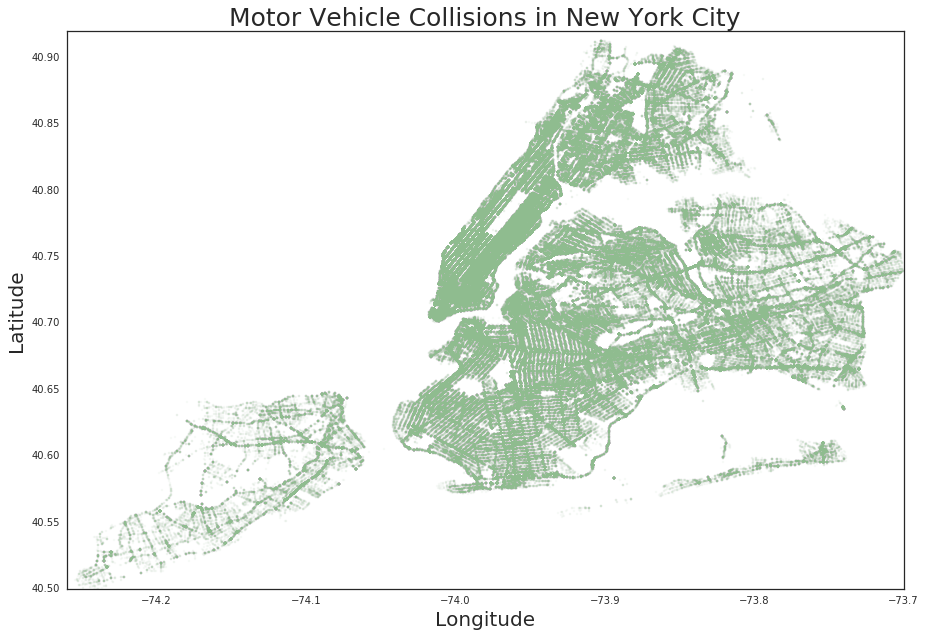

In [11]:
#adjust settings
sns.set_style("white")
plt.figure(figsize=(15,10))

#create scatterplots
plt.scatter(collisions_pd.Longitude, collisions_pd.Latitude, alpha=0.05, s=4, color='darkseagreen')

#adjust more settings
plt.title('Motor Vehicle Collisions in New York City', size=25)
plt.xlim((-74.26,-73.7))
plt.ylim((40.5,40.92))
plt.xlabel('Longitude',size=20)
plt.ylabel('Latitude',size=20)

plt.show()

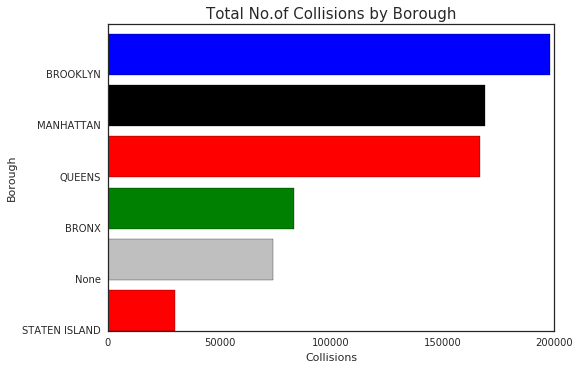

In [12]:
borough = collisions_df.groupBy('BOROUGH').count().sort('count').toPandas()
colors = ['r','0.75','g','r','k','b']
plt.barh(range(6),borough.sort_values(by='count', ascending=True)['count'], color=colors)
plt.xlabel('Collisions')
plt.ylabel('Borough')
plt.title('Total No.of Collisions by Borough', size=15)
plt.yticks(range(6), borough['BOROUGH'])
plt.show()

In [13]:
collisions_header_list

[u'DATE',
 u'TIME',
 u'BOROUGH',
 u'ZIP CODE',
 u'LATITUDE',
 u'LONGITUDE',
 u'LOCATION',
 u'ON STREET NAME',
 u'CROSS STREET NAME',
 u'OFF STREET NAME',
 u'NUMBER OF PERSONS INJURED',
 u'NUMBER OF PERSONS KILLED',
 u'NUMBER OF PEDESTRIANS INJURED',
 u'NUMBER OF PEDESTRIANS KILLED',
 u'NUMBER OF CYCLIST INJURED',
 u'NUMBER OF CYCLIST KILLED',
 u'NUMBER OF MOTORIST INJURED',
 u'NUMBER OF MOTORIST KILLED',
 u'CONTRIBUTING FACTOR VEHICLE 1',
 u'CONTRIBUTING FACTOR VEHICLE 2',
 u'CONTRIBUTING FACTOR VEHICLE 3',
 u'CONTRIBUTING FACTOR VEHICLE 4',
 u'CONTRIBUTING FACTOR VEHICLE 5',
 u'UNIQUE KEY',
 u'VEHICLE TYPE CODE 1',
 u'VEHICLE TYPE CODE 2',
 u'VEHICLE TYPE CODE 3',
 u'VEHICLE TYPE CODE 4',
 u'VEHICLE TYPE CODE 5']